```
!mkdir -p test_image

!gunzip -c /global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data/RomanTDS/images/simple_model/J129/45219/Roman_TDS_simple_model_J129_45219_14.fits.gz > ./test_image/Roman_TDS_simple_model_J129_45219_14.fits

!gunzip -c /global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data/RomanTDS/images/simple_model/J129/166/Roman_TDS_simple_model_J129_166_10.fits.gz > ./test_image/Roman_TDS_simple_model_J129_166_10.fits
```

In [170]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [167]:
import cupy as cp

## Theory

We implement the SIP algorithm for representing non-linear geometric distortion of a linear coordinate transformation ([link](https://irsa.ipac.caltech.edu/data/SPITZER/docs/files/spitzer/shupeADASS.pdf)). SIP transforms a $2D$ coordiante $\begin{pmatrix}
u\\
v
\end{pmatrix}$ to another coordiante $\begin{pmatrix}
x\\
y
\end{pmatrix}$ using the the transformation

\begin{equation}
\begin{pmatrix}
x\\
y
\end{pmatrix}
=
\begin{pmatrix}
\mathrm{CD1\_1} & \mathrm{CD1\_2} \\
\mathrm{CD2\_1} & \mathrm{CD2\_2}
\end{pmatrix}
\begin{pmatrix}
u + f(u, v)\\
v + g(u, v)
\end{pmatrix}
\end{equation}.

$CD$ is a know tranformation matrix. $f$ and $g$ are known polynomials defined as

\begin{equation}
f(u, v) = \sum_{p,q} A\_p\_q u^p v^q, \quad p+q \le \textrm{A_Order}
\end{equation}

and

\begin{equation}
g(u, v) = \sum_{p,q} B\_p\_q u^p v^q, \quad p+q \le \textrm{B_Order}
\end{equation}.

Apply the inverse of the matrix multiplication, we have $U$ and $V$ defined as power series of $u$ and $v$.

\begin{equation}
\begin{pmatrix}
U\\
V
\end{pmatrix}
=
\mathrm{CD}^{-1}
\begin{pmatrix}
x\\
y
\end{pmatrix}
=
\begin{pmatrix}
u + f(u, v)\\
v + g(u, v)
\end{pmatrix}
\end{equation}

The behavior of $U$ and $V$ is smooth in $u$ and $v$. We expect the inverse is also smooth. Thus, we can expand $u$ and $v$ as power series of $U$ and $V$.

\begin{align}
u' = U + F(U, V) = U + \sum_{p,q} AP\_p\_q U^p V^q, \quad p+q \le \textrm{AP_Order}
\end{align}

\begin{align}
v' = V + G(U, V) = V + \sum_{p,q} BP\_p\_q U^p V^q, \quad p+q \le \textrm{BP_Order}
\end{align}

Coefficients $AP\_p\_q$ and $BP\_p\_q$ can be fitted by comparing the residual between true $u$, $v$ and reconstructed $u$, $v$ from $U$, $V$. True $u$, $v$ are sampled from the grid of the image. To avoid unexpected contributions from high order terms, we can add bounds to the corresponding parameters in the fitting space.

## Implementation

In [183]:
# file_path = '/pscratch/sd/s/shl159/Roman/test_image/Roman_TDS_simple_model_J129_166_10.fits'
file_path = '/pscratch/sd/s/shl159/Roman/test_image/Roman_TDS_simple_model_J129_45219_14.fits'
with fits.open(file_path) as hdul:
    header = hdul[1].header
    image = hdul[1].data

In [184]:
truth = Table.read('/global/cfs/cdirs/lsst/shared/external/roman-desc-sims/Roman_data/RomanTDS/truth/J129/45219/Roman_TDS_index_J129_45219_14.txt', format='ascii')

In [189]:
x_phys = x_pixel + header.get('CRPIX1')
y_phys = y_pixel + header.get('CRPIX2')
x_corr = x_phys + header.get('A_0_2') * x_phys**0 * y_phys**2 + 

In [ ]:
A_0_2   =      3.851828071E-10                                                  
A_0_3   =      5.492409696E-14                                                  
A_0_4   =      3.825353128E-18                                                  
A_1_1   =     -1.232185377E-09                                                  
A_1_2   =     -9.743979693E-14                                                  
A_1_3   =       2.66249338E-17                                                  
A_2_0   =      3.802404353E-10                                                  
A_2_1   =     -9.031463862E-14                                                  
A_2_2   =     -6.271302544E-17                                                  
A_3_0   =      2.325088216E-14                                                  
A_3_1   =      2.521067326E-17                                                  
A_4_0 

In [179]:
row = truth[0]
ra, dec, x_pixel, y_pixel = row['ra'], row['dec'], row['x'], row['y']

In [181]:
pixel_to_sky(x_pixel, y_pixel, header)

(11.723552561368757, -46.64803701317142)

In [182]:
ra, dec

(7.63316274, -44.7858517)

2044.0

In [169]:
header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4088                                                  
NAXIS2  =                 4088                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXPTIME =              302.275                                                  
MJD-OBS =            62585.777                                                  
DATE-OBS= '2030-03-25 18:38:52.800000'                                          
FILTER  = 'J129    '                                                            
ZPTMAG  =    17.63810856226013                                                  
GS_XMIN =                   

In [133]:
def get_AB_from_header(header, A_order, B_order, verbose=True):
    """get A, B coefficients from fits header"""
    A = cp.zeros((A_order + 1, A_order + 1))
    B = cp.zeros((B_order + 1, B_order + 1))

    for i in range(0, A_order + 1):
        for j in range(0, A_order - i + 1):
            try:
                A[i,j] = header[f'A_{i}_{j}'] 
            except KeyError:
                if verbose:
                    print(f"Keyword 'A_{i}_{j}' not found, skipping...")
                continue

    for i in range(0, B_order + 1):
        for j in range(0, B_order - i + 1):
            try:
                B[i,j] = header[f'B_{i}_{j}']
            except KeyError:
                if verbose:
                    print(f"Keyword 'B_{i}_{j}' not found, skipping...")
                continue
    return A, B

In [134]:
def sample_grid(u_max, v_max, npoints_in_u_axis, npoints_in_v_axis):
    """Sample pixel points from a grid using CuPy."""
    u_coords = cp.linspace(1, u_max, npoints_in_u_axis)
    v_coords = cp.linspace(1, v_max, npoints_in_v_axis)
    # u_coords = cp.random.uniform(1, u_max, npoints_in_u_axis)
    # v_coords = cp.random.uniform(1, v_max, npoints_in_v_axis)
    u, v = cp.meshgrid(u_coords, v_coords)

    return u, v

def polynomial_sum(u, v, coef):
    """Evaluate the polynomial sum on GPU using CuPy."""
    order = coef.shape[0] - 1
    result = cp.zeros_like(u)
    
    for i in range(order + 1):
        for j in range(order - i + 1):
            result += coef[i, j] * (u**i) * (v**j)
    
    return result

def compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis):
    """Compute u, v, U, V using CuPy."""
    u, v = sample_grid(width - 1, height - 1, npoints_in_u_axis, npoints_in_v_axis)
    f_uv = polynomial_sum(u, v, A)
    g_uv = polynomial_sum(u, v, B)

    U = u + f_uv
    V = v + g_uv

    return u, v, U, V


def compute_UV_bases(U, V, order):
    n_terms = (order + 1) * (order + 2) // 2
    
    result = cp.zeros((U.shape[0], U.shape[1], n_terms))
    
    index = 0
    for i in range(order + 1):
        for j in range(order - i + 1):
            result[:, :, index] = U**i * V**j
            index += 1
            
    return result

def unpack_coef(coef, order):
    """Unpack fitted coefficients from cupy array to dictionary"""
    result = {}
    count = 0
    for i in range(order + 1):
        for j in range(order - i + 1):
            result[f'{i}{j}'] = coef[count]
            count += 1
    return result

In [135]:
A_order = 4
B_order = 4

AP_order = 4
BP_order = 4

width, height = image.shape

In [147]:
A, B = get_AB_from_header(header, A_order, B_order, verbose=True)

Keyword 'A_0_0' not found, skipping...
Keyword 'A_0_1' not found, skipping...
Keyword 'A_1_0' not found, skipping...
Keyword 'B_0_0' not found, skipping...
Keyword 'B_0_1' not found, skipping...
Keyword 'B_1_0' not found, skipping...


In [148]:
npoints_in_u_axis = 200
npoints_in_v_axis = 200
u, v, U, V = compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis, npoints_in_v_axis)

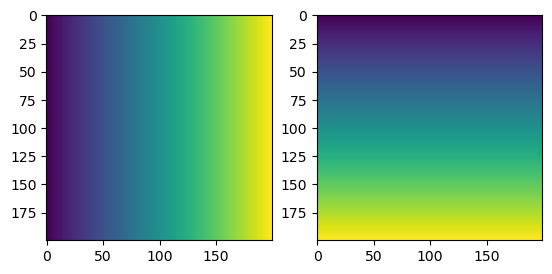

In [149]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(u.get())
axes[1].imshow(v.get())

If AP_order and BP_order are the same, bases only need to be computed once

F_UV_bases = G_UG_bases

In [153]:
F_UV_bases = compute_UV_bases(U, V, AP_order)
G_UV_bases = compute_UV_bases(U, V, BP_order)

Using even sampling can cause numerical degeneracy (Vandermonde matrix and conditioning, Runge's phenomenon, ...), though it does not affect fitting here.

In [154]:
F_UV_bases.reshape(-1, F_UV_bases.shape[2]).get().shape

(40000, 15)

In [155]:
np.linalg.matrix_rank(
    F_UV_bases.reshape(-1, F_UV_bases.shape[2]).get()
)

12

In [156]:
%timeit cp.linalg.lstsq(F_UV_bases.reshape(-1, F_UV_bases.shape[2]), (u - U).reshape(-1, 1) )

5.17 ms ± 477 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [157]:
AP_coef, u_res, _, _ = cp.linalg.lstsq(
    F_UV_bases.reshape(-1, F_UV_bases.shape[2]),
    (u - U).reshape(-1, 1)
)

BP_coef, v_res, _, _ = cp.linalg.lstsq(
    G_UV_bases.reshape(-1, G_UV_bases.shape[2]),
    (v - V).reshape(-1, 1)
)

AP = unpack_coef(AP_coef, AP_order)
BP = unpack_coef(BP_coef, BP_order)

In [158]:
u_res, v_res

(array([2.65935468e-13]), array([1.78368748e-13]))

## Test on 2000 $\times$ 2000 grid

In [159]:
import matplotlib.pyplot as plt

In [160]:
u, v, U, V = compute_uv_UV(width, height, A, B, AP_order, BP_order, npoints_in_u_axis=200, npoints_in_v_axis=200)
# If AP_order and BP_order are the same, bases only need to be computed once
# F_UV_bases = G_UG_bases
F_UV_bases = compute_UV_bases(U, V, AP_order)
G_UV_bases = compute_UV_bases(U, V, BP_order)

In [161]:
F_UV = cp.squeeze(
    cp.tensordot(F_UV_bases, AP_coef, axes=((2), (0)))
)
G_UV = cp.squeeze(
    cp.tensordot(G_UV_bases, BP_coef, axes=((2), (0)))
)

Text(0.5, 1.0, 'v')

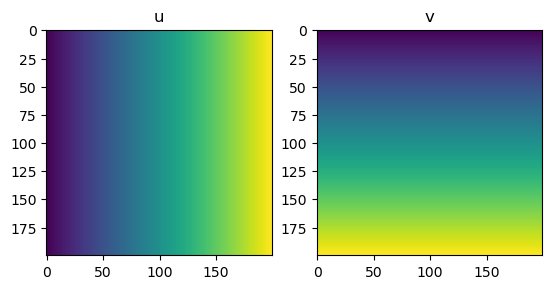

In [162]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(u.get())
axes[0].set_title('u')
axes[1].imshow(v.get())
axes[1].set_title('v')

Text(0.5, 1.0, 'V')

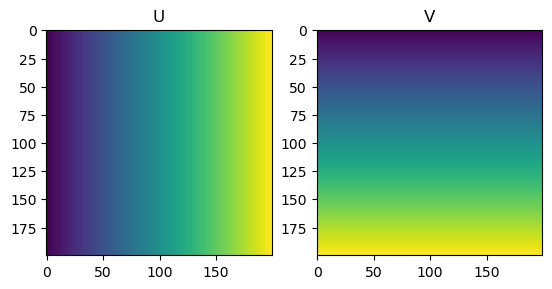

In [163]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(U.get())
axes[0].set_title('U')
axes[1].imshow(V.get())
axes[1].set_title('V')

Text(0.5, 1.0, 'v - V - G_UV')

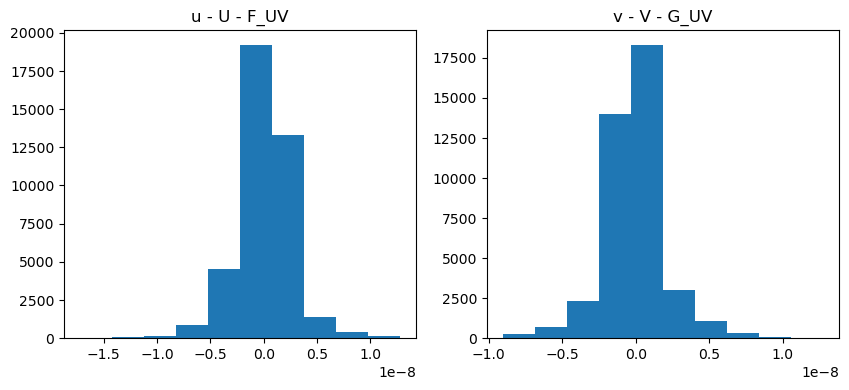

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist((u - U - F_UV).get().ravel())
axes[0].set_title('u - U - F_UV')
axes[1].hist((v - V - G_UV).get().ravel())
axes[1].set_title('v - V - G_UV')

Text(0.5, 1.0, 'v - V')

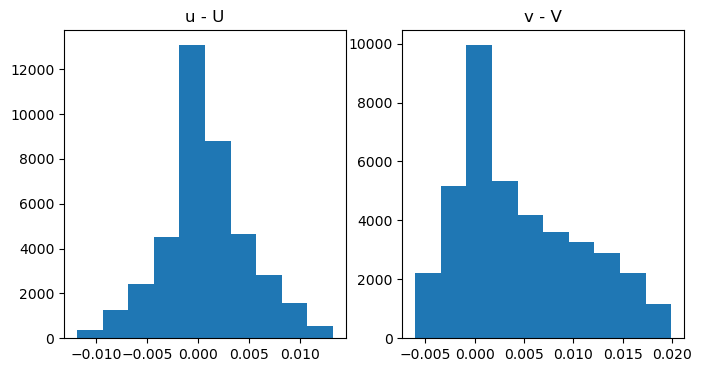

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist((u - U).get().ravel())
axes[0].set_title('u - U')
axes[1].hist((v - V).get().ravel())
axes[1].set_title('v - V')